In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib

In [4]:
# Api imports
import requests

In [3]:
import pathlib


def get_images_directory(directory):
    data_dir = pathlib.Path(directory)
    return data_dir

# Look at directory

In [41]:
! pwd

/home/noel/code/DSP-Tan/mushroom_learning/notebooks


In [42]:
! ls -rtlh ../raw_data/fungi_identification/images/

total 7.5M
drwxr-xr-x 2 noel noel 4.0K Mar 27  2018  41004_Calocybe_ionides
drwxr-xr-x 2 noel noel 4.0K Mar 27  2018  41002_Calocybe_carnea
drwxr-xr-x 2 noel noel  20K Mar 27  2018  40985_Byssomerulius_corium
drwxr-xr-x 2 noel noel 4.0K Mar 27  2018  16435_Aspropaxillus_giganteus
drwxr-xr-x 2 noel noel 4.0K Mar 27  2018  16423_Leucogyrophana_mollusca
drwxr-xr-x 2 noel noel 4.0K Mar 27  2018  16411_Leucocoprinus_brebissonii
drwxr-xr-x 2 noel noel 4.0K Mar 27  2018  16390_Leucoagaricus_leucothites
drwxr-xr-x 2 noel noel  12K Mar 27  2018  65745_Suillellus_luridus
drwxr-xr-x 2 noel noel 4.0K Mar 27  2018  16593_Lycoperdon_lividum
drwxr-xr-x 2 noel noel 4.0K Mar 27  2018  16588_Lycoperdon_echinatum
drwxr-xr-x 2 noel noel 4.0K Mar 27  2018  16587_Lycoperdon_decipiens
drwxr-xr-x 2 noel noel 4.0K Mar 27  2018  16582_Lycogala_flavofuscum
drwxr-xr-x 2 noel noel 4.0K Mar 27  2018  16580_Lycogala_epidendrum
drwxr-xr-x 2 noel noel 4.0K Mar 27  2018  16477_Limacella_guttata
drwxr-xr-x 2 noel noel 4

## Find number of species

### linux method

In [46]:
ls -rtlh ../raw_data/fungi_identification/images/ | wc

   1395   12627  112478


In [47]:
num_species=1395

### Python method

In [22]:
import os, sys

path_to_imgs='../raw_data/fungi_identification/images/'

# listing directories
species_dir_list=os.listdir(path_to_imgs)

# renaming directory 
#os.rename("old_name","new_name")
# you can list again after if you like

In [5]:
species_dir_list[1]

'11317_Cantharellus_cibarius'

#### check for spaces in names

In [23]:
for i in species_dir_list:
    if ' ' in i:
        print(i)

**There are none**

#### Get rid of spaces in directory names

In [ ]:
for i in species_list:
    if ' ' in i:
        mytable = i.maketrans(" ", "_")
        i_new=i.translate(mytable)
        os.rename(path_to_imgs+i,path_to_imgs+i_new)

In [ ]:
#### Count number of species

In [8]:
print(f'We have {len(species_dir_list)} different species')

We have 1397 different species


In [127]:
def find_species(species_name,species_list):
    '''
    This takes a species name as a string, which should have an _ between the genus and species,
    and returns its containing directory to you. It must 
    '''
    for i in species_list:
        if species_name.lower() in i.lower():
            return path_to_imgs+i

In [128]:
amanites=find_species('amanita_muscaria',species_dir_list)
print(amanites)

../raw_data/fungi_identification/images/10252_Amanita_muscaria


## Find number of photos of each species

In [125]:
def num_of_species(spec_dir):
    return len( list(os.listdir(spec_dir)) )

In [129]:
num_of_species(find_species('amanita_muscaria',species_dir_list))

163

In [20]:
!pwd

/home/noel/code/DSP-Tan/mushroom_learning/notebooks


In [24]:
spec='species'
num='num'
print(f'{spec:30} {num:30}')
spec_names=[]
spec_num_phots=[]
for i in species_dir_list:
    #This skips the files folder_analysis.sh and folders.txt which are here and are not directories.
    if 'folder' in i:
        continue
    #print(f'{i:50} {len(list(os.listdir(path_to_imgs+i)))}')
    spec_names.append(i)
    spec_num_phots.append(len(list(os.listdir(path_to_imgs+i))))
    
zipped = list(zip(spec_names, spec_num_phots))
df = pd.DataFrame(zipped, columns=['Name', '# photos'])
df.head()

species                        num                           


,Name,# photos
0,67237_Hortiboletus_engelii,64
1,11317_Cantharellus_cibarius,144
2,20739_Suillus_variegatus,50
3,13953_Exidia_pithya,21
4,14815_Hygrocybe_acutoconica,143


### Identify top 20 for choice of what species to detect. 

In [28]:
df.sort_values('# photos',ascending=False).head(20)

,Name,# photos
648,18882_Plicatura_crispa,442
875,18890_Pluteus_cervinus,419
1000,21143_Tricholoma_scalpturatum,414
21,11082_Xerocomellus_chrysenteron,406
1195,17233_Mycena_galericulata,375
768,40985_Byssomerulius_corium,374
416,12919_Cylindrobasidium_laeve,364
760,40392_Armillaria_lutea,352
364,14160_Ganoderma_pfeifferi,342
814,61207_Coprinellus_micaceus,340


In [27]:
data_dir=get_images_directory('../raw_data/fungi_identification/images/')

In [29]:
image_count = len(list(data_dir.glob('*/*.JPG')))
print(image_count)

89760


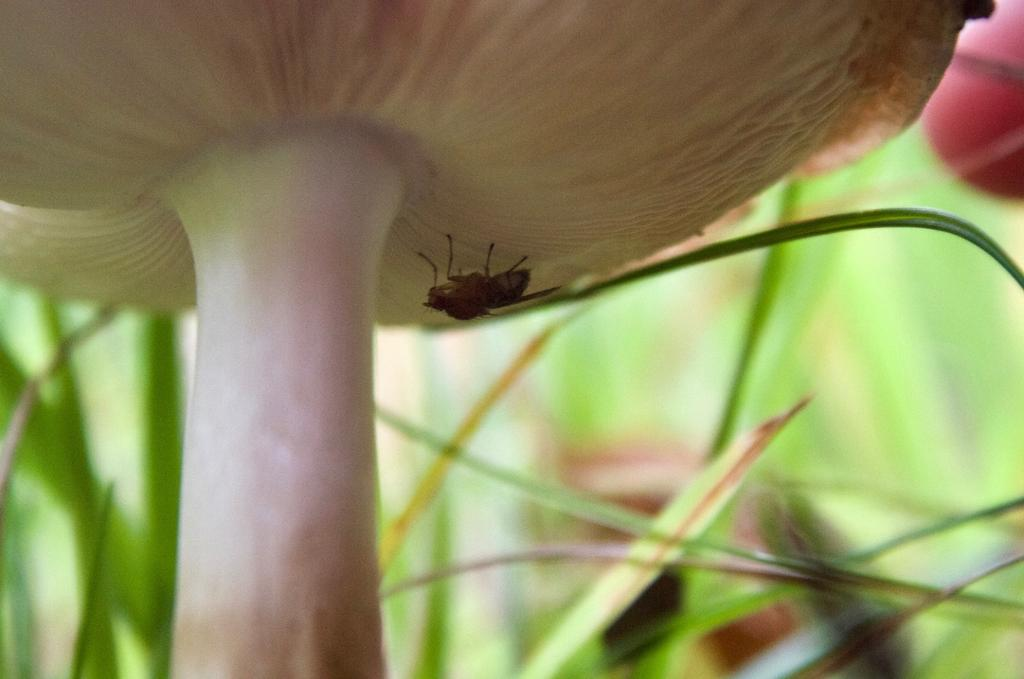

In [38]:
death_caps= list(data_dir.glob('63478_Amanita_phalloides/*'))

PIL.Image.open(str(death_caps[8]))

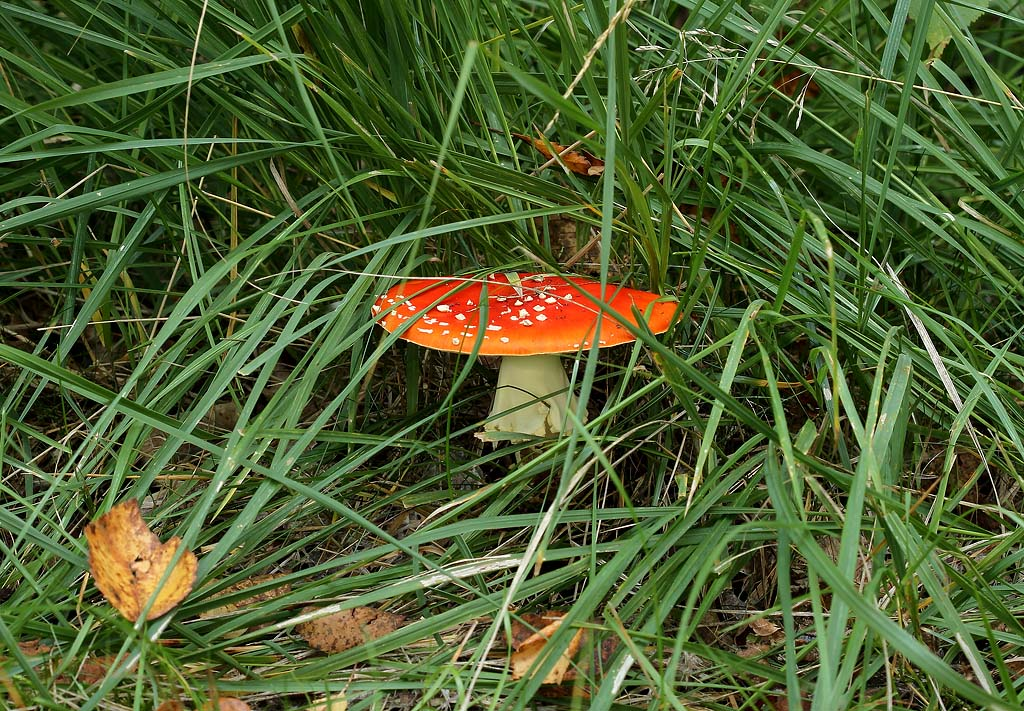

In [40]:
# fly_agaric is the common name for Amanita_muscaria
fly_agarics = list(data_dir.glob('10252_Amanita_muscaria/*'))
PIL.Image.open(str(fly_agarics[5]))

In [15]:
! ls -rtlh '../raw_data/fungi_identification/images/10000_Abortiporus_biennis/'

total 13M
-rwxr-xr-x 1 noel noel  90K Mar 27  2018 TAK2013PIC88720592.JPG
-rwxr-xr-x 1 noel noel  39K Mar 27  2018 TAK2013PIC62285572.JPG
-rwxr-xr-x 1 noel noel  79K Mar 27  2018 TAK2013PIC54332935.JPG
-rwxr-xr-x 1 noel noel  94K Mar 27  2018 TAK2013PIC27408119.JPG
-rwxr-xr-x 1 noel noel  90K Mar 27  2018 TAK2013PIC20706634.JPG
-rwxr-xr-x 1 noel noel 257K Mar 27  2018 TAK2012PIC72021149.JPG
-rwxr-xr-x 1 noel noel 248K Mar 27  2018 TAK2012PIC67497794.JPG
-rwxr-xr-x 1 noel noel 197K Mar 27  2018 TAK2012PIC15977230.JPG
-rwxr-xr-x 1 noel noel 135K Mar 27  2018 SVEND2012PIC66041655.JPG
-rwxr-xr-x 1 noel noel 137K Mar 27  2018 SVEND2011PIC54116904.JPG
-rwxr-xr-x 1 noel noel 161K Mar 27  2018 PEL2011PIC77558983.JPG
-rwxr-xr-x 1 noel noel 189K Mar 27  2018 PEL2011PIC10752571.JPG
-rwxr-xr-x 1 noel noel 114K Mar 27  2018 JAH2016-9177436_rJlvcUxNR.JPG
-rwxr-xr-x 1 noel noel 147K Mar 27  2018 JAH2016-9177436_Hkw9IeER.JPG
-rwxr-xr-x 1 noel noel 116K Mar 27  2018 JAH2015PIC61175654.JPG
-rwxr-xr-x 1 

In [ ]:
def get_images_directory(directory):
    data_dir = pathlib.Path(directory)
    return data_dir